In [1]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn
#!pip install scipy

In [2]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, sqrt, atan2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer,OneHotEncoder
from scipy.sparse import hstack,csr_matrix

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,recall_score,classification_report

## Load Data in train and test

In [4]:
train = pd.read_csv("../Dataset/credit_card_transaction_train.csv")
test = pd.read_csv("../Dataset/credit_card_transaction_test.csv")

## Basic Analysis of Datasets

In [5]:
train.shape, test.shape

((1296675, 24), (555719, 24))

In [6]:
all(train.columns == test.columns)

True

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [9]:
#Null Values
nullsTrain=train.isna().sum()
nullsTrain=nullsTrain[nullsTrain>0]

nullsTest=test.isna().sum()
nullsTest=nullsTest[nullsTest>0]

nullsPercentTrain=nullsTrain/train.shape[0]
nullsPercentTest=nullsTest/test.shape[0]

nullsPercentTrain , nullsPercentTest

(merch_zipcode    0.151135
 dtype: float64,
 merch_zipcode    0.151125
 dtype: float64)

## Removing Null values
- Null values contribute to 15% of training data. 
- Testing data should be clean.

In [10]:
#Removing Null Values
train.dropna(inplace=True,axis=0)
test.dropna(inplace=True,axis=0)

In [11]:
train.shape, test.shape

((1100702, 24), (471736, 24))

.

## Feature Engineering (Converting DoB to Age)

In [12]:
train['dob'] = pd.to_datetime(train['dob'])
test['dob'] = pd.to_datetime(test['dob'])

In [13]:
train['age'] = 2024 - train['dob'].dt.year
test['age'] = 2024 - test['dob'].dt.year

In [14]:
train.drop("dob",axis=1,inplace=True)
test.drop("dob",axis=1,inplace=True)

## Feature Engineering (Calculating Distance Between Customer & Merchant)

In [15]:
# Transaction Distance: Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [16]:
train['transaction_distance'] = train.apply(
    lambda x: haversine(x['lat'], x['long'], x['merch_lat'], x['merch_long']), axis=1)

In [17]:
test['transaction_distance'] = test.apply(
    lambda x: haversine(x['lat'], x['long'], x['merch_lat'], x['merch_long']), axis=1)

## Feature Engineering (Transaction Frequency)

In [18]:
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])
test['trans_date_trans_time'] = pd.to_datetime(test['trans_date_trans_time'])

In [19]:
train['trans_date_trans_time'] = train['trans_date_trans_time'].dt.date
test['trans_date_trans_time'] = test['trans_date_trans_time'].dt.date

In [20]:
train['trans_count_per_day'] = train.groupby(['cc_num', 'trans_date_trans_time'])['trans_date_trans_time'].transform('count')
test['trans_count_per_day'] = test.groupby(['cc_num', 'trans_date_trans_time'])['trans_date_trans_time'].transform('count')

## Remove index and unwanted columns

In [21]:
#Remove index columns
colsToDrop= ['trans_date_trans_time','Unnamed: 0','cc_num','first','last','trans_num','street','city']
train.drop(colsToDrop,axis=1,inplace=True)
test.drop(colsToDrop,axis=1,inplace=True)

In [22]:
train.shape, test.shape

((1100702, 18), (471736, 18))

## Treat Class-Imbalance

C:\Users\dbda\AppData\Local\Temp\ipykernel_12240\592855909.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(train['is_fraud'])


Text(0, 0.5, 'Frequency')

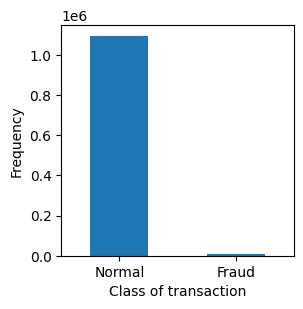

In [23]:
# plotting the classes
plt.figure(figsize=(3,3))
count_classes = pd.value_counts(train['is_fraud'])
count_classes.plot(kind = 'bar',rot=0)
LABELS = ['Normal','Fraud']
plt.xticks(range(2), LABELS)
plt.xlabel("Class of transaction")
plt.ylabel("Frequency")

In [24]:
print(count_classes.iloc[0]/count_classes.iloc[1])

171.98475561841897


#### Should opt for "class_weight= " parameter in ML model b/s ratio approx. 172:1 is fair enough good than 1000:1

.

## Spliting Independent and Dependent variables

In [25]:
x_train = train.drop("is_fraud",axis=1)
x_test  = test.drop("is_fraud",axis=1)

y_train = train["is_fraud"]
y_test  = test["is_fraud"]

In [26]:
x_train.shape , x_test.shape, y_train.shape, y_test.shape

((1100702, 17), (471736, 17), (1100702,), (471736,))

## Data Transofrmation(Yeo-Johnson) and Standard Scaling

In [27]:
x_train.select_dtypes(exclude="object").skew()

amt                     44.548930
zip                      0.142397
lat                     -0.349471
long                    -1.052179
city_pop                 5.600689
unix_time                0.003182
merch_lat               -0.340692
merch_long              -1.051067
merch_zipcode            0.145648
age                      0.584993
transaction_distance    -0.212812
trans_count_per_day      1.468756
dtype: float64

<Axes: xlabel='amt', ylabel='Density'>

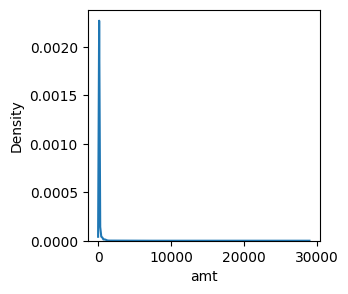

In [28]:
plt.figure(figsize=(3,3))
sns.kdeplot(x_train["amt"], label="amt")

In [29]:
#Using PowerTransformer
TransformModel = PowerTransformer(method='yeo-johnson',standardize=True)
TransformModel.fit(x_train.select_dtypes(exclude="object"))

PowerTransformer()

In [30]:
numeric_cols = x_train.select_dtypes(exclude="object").columns

In [31]:
x_train[numeric_cols] = TransformModel.transform(x_train[numeric_cols])
x_test[numeric_cols] = TransformModel.transform(x_test[numeric_cols])

In [32]:
x_train.shape , x_test.shape

((1100702, 17), (471736, 17))

In [33]:
x_train.select_dtypes(exclude="object").skew()

amt                    -0.014016
zip                    -0.188598
lat                    -0.045696
long                   -0.052577
city_pop                0.059247
unix_time              -0.002061
merch_lat              -0.046212
merch_long             -0.052247
merch_zipcode          -0.184831
age                    -0.010007
transaction_distance   -0.160462
trans_count_per_day     0.004092
dtype: float64

<Axes: xlabel='amt', ylabel='Density'>

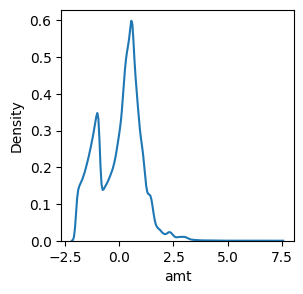

In [34]:
plt.figure(figsize=(3,3))
sns.kdeplot(x_train["amt"], label="amt")

#### There still lots of values beyond 6-Sigma so, have to Impute outliers to ensure normality as well as prevent data loss  

## Outlier Handling

In [35]:
def outRemove(x):
    if x>3: return 3
    elif x<-3: return -3
    else: return x

In [36]:
x_train[numeric_cols] = x_train[numeric_cols].applymap(outRemove)
x_test[numeric_cols] = x_test[numeric_cols].applymap(outRemove)

C:\Users\dbda\AppData\Local\Temp\ipykernel_12240\982681809.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  x_train[numeric_cols] = x_train[numeric_cols].applymap(outRemove)
C:\Users\dbda\AppData\Local\Temp\ipykernel_12240\982681809.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  x_test[numeric_cols] = x_test[numeric_cols].applymap(outRemove)


<Axes: xlabel='amt', ylabel='Density'>

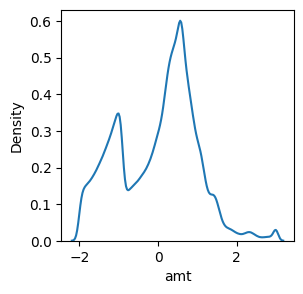

In [37]:
plt.figure(figsize=(3,3))
sns.kdeplot(x_train["amt"], label="amt")

## Encoding 

In [38]:
x_train.dtypes

merchant                 object
category                 object
amt                     float64
gender                   object
state                    object
zip                     float64
lat                     float64
long                    float64
city_pop                float64
job                      object
unix_time               float64
merch_lat               float64
merch_long              float64
merch_zipcode           float64
age                     float64
transaction_distance    float64
trans_count_per_day     float64
dtype: object

### Have to use Sparse Matrix for OneHot Encoding due large size of data

In [39]:
x_train.head()

,merchant,category,amt,gender,state,zip,lat,long,city_pop,job,unix_time,merch_lat,merch_long,merch_zipcode,age,transaction_distance,trans_count_per_day
0,"fraud_Rippin, Kub and Mann",misc_net,-1.320840,F,NC,-0.607863,-0.594835,0.563398,0.055191,"Psychologist, counselling",-1.863736,-0.608509,0.465019,-0.617740,-0.846151,0.114764,-0.376643
2,fraud_Lind-Buckridge,entertainment,1.539206,M,ID,1.312087,0.788460,-1.654983,0.131564,Nature conservation officer,-1.863733,1.025493,-1.650513,1.314035,0.723553,1.143003,-1.775558
4,fraud_Keeling-Crist,misc_pos,0.117777,M,VA,-0.794243,-0.091899,0.768853,-1.926591,Dance movement psychotherapist,-1.863722,-0.035774,0.874015,-0.880192,-0.696622,0.078987,0.063910
5,"fraud_Stroman, Hudson and Erdman",gas_transport,0.783936,F,PA,-1.054852,0.354408,1.342791,-0.166549,Transport planner,-1.863718,0.417981,1.206922,-1.115580,0.772013,0.367320,-1.775558
7,fraud_Corwin-Collins,gas_transport,0.549313,M,VA,-0.868044,0.002531,0.877434,0.290206,"Designer, multimedia",-1.863713,0.025419,0.885813,-0.889511,1.390986,-2.066692,-0.376643


In [40]:
non_numeric_cols = x_train.select_dtypes("object").columns

In [41]:
x_train[non_numeric_cols].nunique()

merchant    693
category     14
gender        2
state        50
job         493
dtype: int64

In [42]:
x_train_NonNumeric = x_train[non_numeric_cols]
x_train_Numeric = x_train[numeric_cols]

x_test_NonNumeric = x_test[non_numeric_cols]
x_test_Numeric = x_test[numeric_cols]

In [43]:
enCoder = OneHotEncoder(handle_unknown='ignore',drop="first",sparse_output=True)
enCoder.fit(x_train_NonNumeric)

OneHotEncoder(drop='first', handle_unknown='ignore')

In [44]:
x_train_NonNumeric_np = enCoder.transform(x_train_NonNumeric)
x_test_NonNumeric_np = enCoder.transform(x_test_NonNumeric)

C:\Users\dbda\AppData\Local\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [45]:
x_train_Numeric_np = csr_matrix(x_train_Numeric.values)
x_test_Numeric_np = csr_matrix(x_test_Numeric.values)

In [46]:
x_train_np = hstack([x_train_Numeric_np, x_train_NonNumeric_np])
x_test_np = hstack([x_test_Numeric_np, x_test_NonNumeric_np])

.

# Model Building Without UnderSampling and Feature Selection

In [51]:
logic_Regress_model = LogisticRegression(class_weight='balanced',random_state=117,max_iter=150,solver='saga')
logic_Regress_model.fit(x_train_np,y_train)

C:\Users\dbda\AppData\Local\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=150, random_state=117,
                   solver='saga')

In [52]:
DC_model = DecisionTreeClassifier(class_weight='balanced',random_state=117)
DC_model.fit(x_train_np,y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=117)

In [54]:
y_pred_logic_Regress = logic_Regress_model.predict(x_test_np)

In [55]:
y_pred_DC = DC_model.predict(x_test_np)

In [59]:
print("->Logistic_Regression:\n",classification_report(y_test,y_pred_logic_Regress),"\n")
print("->Decision_Tree_Classifier:\n",classification_report(y_test,y_pred_DC),"\n")

->Logistic_Regression:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80    469863
           1       0.01      0.60      0.01      1873

    accuracy                           0.67    471736
   macro avg       0.50      0.64      0.41    471736
weighted avg       0.99      0.67      0.80    471736
 

->Decision_Tree_Classifier:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    469863
           1       0.59      0.37      0.46      1873

    accuracy                           1.00    471736
   macro avg       0.79      0.69      0.73    471736
weighted avg       1.00      1.00      1.00    471736
 

